### Load Module

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as ly

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import _pickle as pickle
import pandas as pd
from collections import defaultdict

from scipy.signal import savgol_filter as sg

### Parameter

In [2]:
# Inputs:Global parameters 
batch_size = 32
img_dim = 688
y_dim = 1 # the number of continous variables
is_adam = True
learning_rate_cnn = 2e-4

# Train : Prameters
max_iter_step = 10000
device = '/gpu:0'
data_format = 'NCHW'
channel = 1
# directory to store log ,include loss  and grad_norm of generator and critic
rgan_dir = './Inproved_rgan/RGAN/Experient_1'
cnn_dir = rgan_dir+'/cnn_ckpt'
if not os.path.exists(cnn_dir):
    os.makedirs(cnn_dir)
else:
    shutil.rmtree(cnn_dir)
    os.makedirs(cnn_dir)

### Load dataset

In [19]:
# from database load the data and label,clip the length network required
spect = scio.loadmat('NMR_Index.mat')
x,y = spect['NMR'],spect['Index'][:,3]
if x.shape[1]>img_dim:
    x = x[:,:img_dim]

In [52]:
fig = plt.figure(figsize=(4,3), dpi=1500, facecolor="white")
# plot raw data 
plt.plot(np.arange(688),x.transpose(),'-',linewidth=0.7)
plt.xlabel('Chemical Shift/ppm',fontsize=8)
plt.ylabel(r'Intensity ',fontsize=8)
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.savefig(cnn_dir+'/spect.png')
#plt.show()

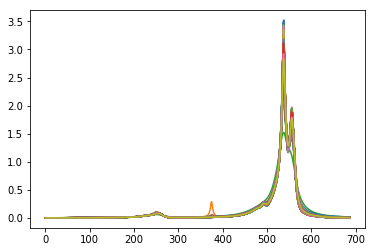

In [3]:
# pre_processing by minmaxmap
xmin, xmax, ymin, ymax = x.min(),x.max(), y.min(),y.max()
xmid,ymid = (xmin+xmax)/2,(ymin+ymax)/2
x,y = (x - xmid)*2/( xmax - xmin ),(y - ymid)*2/( ymax - ymin )

# reshape the data to the format that look like image
x= x.reshape(-1,1,img_dim,1)
y= y.reshape(-1,y_dim)
## split the dataset
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.20,random_state=0)

### Build cnn

In [4]:
def lrelu(x,leak=0.2,name='lrelu'):
    with tf.variable_scope('lrelu'):
        f1 = 0.5*(1+leak)
        f2 = 0.5*(1-leak)
        return f1*x + f2*abs(x)

In [5]:
def cnn_conv(x):
    size = 16
    cnn = ly.conv2d(x,num_outputs=size*8,kernel_size=[10,1],stride=[2,1],padding='SAME',
                       activation_fn = lrelu,data_format=data_format,
                       weights_initializer = tf.random_normal_initializer(0,0.02))
    
#     cnn = ly.conv2d(cnn,num_outputs= size*8 ,kernel_size=[10,1],stride=[1,1],padding='SAME',
#                         activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
#                         normalizer_params ={'fused':True,'data_format':data_format},
#                         weights_initializer = tf.random_normal_initializer(0,0.02))
    
#     cnn = ly.conv2d(cnn,num_outputs= size*16,kernel_size=[10,1],stride=[2,1],padding='SAME',
#                         activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
#                         normalizer_params ={'fused':True,'data_format':data_format},
#                         weights_initializer = tf.random_normal_initializer(0,0.02))
    
#     cnn = ly.conv2d(cnn,num_outputs= size*32,kernel_size=[10,1],stride=[2,1],padding='SAME',
#                         activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
#                         normalizer_params ={'fused':True,'data_format':data_format},
#                         weights_initializer = tf.random_normal_initializer(0,0.02))
        
    cnn = ly.flatten(cnn)
    cnn = ly.fully_connected(cnn,1024,activation_fn=lrelu,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format})
#     cnn = ly.fully_connected(cnn,512,activation_fn=lrelu,normalizer_fn = ly.batch_norm,
#                         normalizer_params ={'fused':True,'data_format':data_format})
    out = ly.fully_connected(cnn,y_dim,activation_fn=tf.nn.tanh)
    
    return out

### Build Graph & Loss

In [6]:
def build_graph():
    # Input
    x = tf.placeholder(dtype=tf.float32,shape=[None,channel,img_dim,1])
    y = tf.placeholder(dtype=tf.float32,shape=[None,y_dim])
    
    # Graph
    with tf.variable_scope('generator'):
        predict = cnn_conv(x)
    
    # Loss
    cnn_loss = tf.reduce_mean(tf.reduce_sum(0.5*tf.square(predict-y),reduction_indices=1))
    
    # Parameters
    theta_cnn = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope ='generator')
    
    # Optimizers
    counter_g = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_cnn = optimize(loss = cnn_loss, variables =theta_cnn,learning_rate =  learning_rate_cnn,
                      optimizer = tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                      global_step = counter_g)
    
    return opt_cnn,x,y,cnn_loss,predict

In [7]:
def optimize(loss,learning_rate,optimizer, variables,global_step):
    optim = optimizer(learning_rate = learning_rate)
    
    gradients = optim.compute_gradients(loss, var_list = variables)
    
    return optim.apply_gradients(gradients,global_step = global_step)

In [8]:
def train_cnn( max_iters=max_iter_step):
    with tf.device(device):
        opt_cnn, x, y, cnn_loss,predict = build_graph()
    saver = tf.train.Saver()
    
    def next_feed_dict(iter, shuffled=True , is_test=False):
        def generate_index(input,iter,shuffled =False):
            input_number = input.shape[0]
            if shuffled:
                idx = np.random.randint(input_number,size=(batch_size,))
            else:
                bat_num = int(input_number/batch_size)
                par = int(iter % bat_num)
                idx = np.arange(input_number)[par * batch_size:(par+1)*batch_size]
            return idx
        
        if is_test:
            idx = generate_index(x_test,iter)
            feed_img,feed_label = x_test[idx],y_test[idx]
        else:
            idx = generate_index(x_train,iter)
            feed_img,feed_label = x_train[idx],y_train[idx]
            
        
        feed_dict = {x:feed_img, 
                     y:feed_label}
        
        return feed_dict
    
    config = tf.ConfigProto(allow_soft_placement= True,log_device_placement=True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    
    
    with tf.Session(config = config) as sess:
        sess.run(tf.global_variables_initializer())
        
        hist_loss = defaultdict(list)
        for i in range(max_iters):
            
            # Training
            feed_dict = next_feed_dict(i)
            _,t_loss = sess.run([opt_cnn,cnn_loss], feed_dict = feed_dict)
            hist_loss['Training'].append(t_loss)
            
            # Testing
            feed_dict = next_feed_dict(i,is_test = True)
            s_loss = sess.run(cnn_loss,feed_dict = feed_dict)
            hist_loss['Testing'].append(s_loss)
            
            if i % 100 ==0:
                print('Iteration: {:>5d} of {}:{:>15.4f}|{:<15.4f}'.format(i ,max_iters,t_loss,s_loss))
            
            if i % 100 ==0:
                saver.save(sess,os.path.join(cnn_dir ,'model_checkpoint'),global_step=i)
        
        pickle.dump(hist_loss, open(rgan_dir+'/cnn_pickle.pkl','wb'))
        

In [29]:
tf.reset_default_graph()
train_cnn(max_iters=20000)

Iteration:     0 of 20000:         0.1008|0.0992         
Iteration:   100 of 20000:         0.0432|0.0429         
Iteration:   200 of 20000:         0.0176|0.0213         
Iteration:   300 of 20000:         0.0071|0.0393         
Iteration:   400 of 20000:         0.0135|0.0281         
Iteration:   500 of 20000:         0.0084|0.0225         
Iteration:   600 of 20000:         0.0083|0.0288         
Iteration:   700 of 20000:         0.0060|0.0229         
Iteration:   800 of 20000:         0.0059|0.0209         
Iteration:   900 of 20000:         0.0093|0.0290         
Iteration:  1000 of 20000:         0.0049|0.0333         
Iteration:  1100 of 20000:         0.0062|0.0193         
Iteration:  1200 of 20000:         0.0200|0.0269         
Iteration:  1300 of 20000:         0.0030|0.0272         
Iteration:  1400 of 20000:         0.0045|0.0201         
Iteration:  1500 of 20000:         0.0363|0.1093         
Iteration:  1600 of 20000:         0.0068|0.0549         
Iteration:  17

### Show The Result & Contrast

Load from RGAN

In [69]:
def iter_to_epoch(p,x_input):
    one_epoch_iters = int(x_input.shape[0]/batch_size)+1
    eopchs = int(len(p) / one_epoch_iters)
    loss = np.zeros([eopchs,1])
    for i in range(eopchs):
        loss[i] = np.mean([p[i*one_epoch_iters:(i+1)*one_epoch_iters]])
    return loss

In [30]:
hist_ = pickle.load(open('./Inproved_rgan/RGAN/Experient_6'+'/rgan_pickle.pkl','rb'))

In [31]:
losses = ['generator','discriminator','Q network','Q_continous','Q_categorical']
for p in hist_.keys():
    hist_[p] = pd.DataFrame(hist_[p],columns=losses)

In [74]:
loss_ =[]
for p in hist_.keys():
    p_ = np.array(hist_[p]['Q network'])
    #loss_.append(sg(p_ , window_length=9 , polyorder=1))
    loss_.append(p_)

Load from CNN

In [34]:
hist = pickle.load(open(rgan_dir+'/cnn_pickle.pkl','rb'))

In [35]:
loss = []
for p in hist.keys():
    p_ = np.array(hist[p])
    #loss.append(sg(p_ , window_length=9 , polyorder=1))
    loss.append(p_)

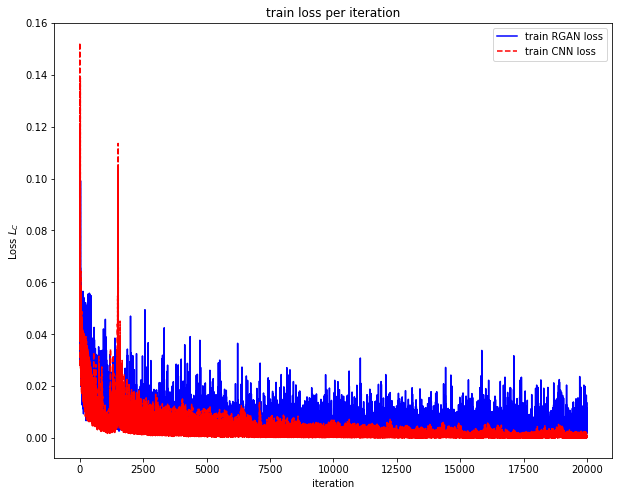

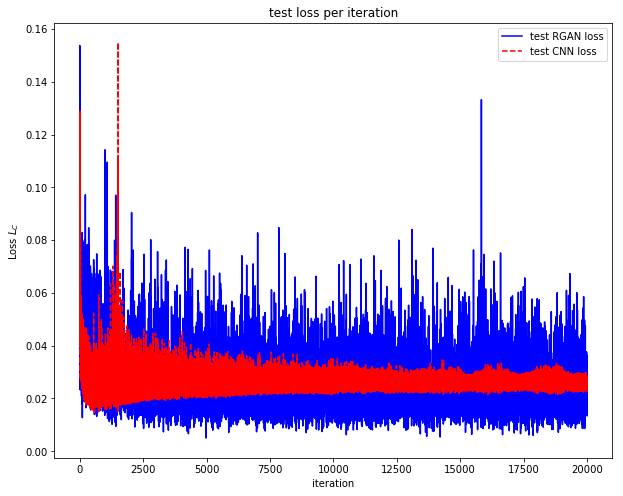

In [36]:
for p,q,s in zip(loss_ ,loss ,['train','test']):
    plt.figure(figsize=[10,8])
    plt.plot(np.arange(len(p)),p,'b-',np.arange(len(q)),q,'--r',ms=4) 
    plt.legend([s+' RGAN loss',s+' CNN loss'])
    plt.title(s+' loss per iteration')
    plt.xlabel('iteration')
    plt.ylabel(r'Loss $L_C$ ')
    plt.show()

In [37]:
def test(cnn_dir=cnn_dir,test_epoch=5000):
    
    with tf.Session(config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
        # build graph
        with tf.device(device):
            opt_cnn, x, y, cnn_loss,predict = build_graph()
        
        # use saver to reload the parametes
        saver = tf.train.Saver()
        #saver.restore(sess, './Inproved_rgan/cgan_2d/Experient_1/ckpt_rgan\\model_checkpoint-17000')
        saver.restore(sess,cnn_dir+'\\model_checkpoint-'+str(test_epoch))
        
        ###########################################  Experiment : Generator #################
        # Gererate random labels as conditions , [0,1] gausson distribution
        def cv_proc(y):
            y = ymid + y*(ymax-ymin)/2
            return y
        
        y_train_predict,y_test_predict = cv_proc(sess.run(predict,{x:x_train})),cv_proc(sess.run(predict,{x:x_test}))
        r_train,r_test = r2_score(cv_proc(y_train),y_train_predict),r2_score(cv_proc(y_test),y_test_predict)
    
    return [y_train_predict,cv_proc(y_train)],[y_test_predict,cv_proc(y_test)],[r_train,r_test]

In [38]:
tf.reset_default_graph()
y_train_ ,y_test_,r_ = test(test_epoch=19900)

INFO:tensorflow:Restoring parameters from ./Inproved_rgan/RGAN/Experient_1/cnn_ckpt\model_checkpoint-19900


In [39]:
print('r -> {:.3f} | {:.3f}'.format(*r_))

r -> 0.952 | 0.730


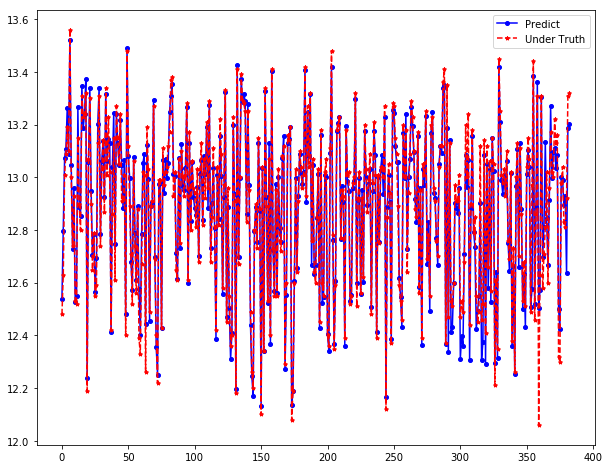

In [40]:
x_limit = np.arange(len(y_train_[1]))
plt.figure(figsize=[10,8])
plt.plot(x_limit,y_train_[0],'b-o',x_limit,y_train_[1],'--r*',ms=4)
plt.legend(['Predict','Under Truth'])
plt.show()

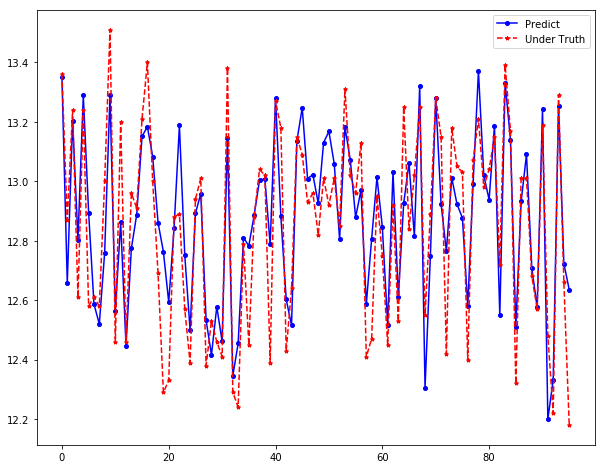

In [41]:
x_limit = np.arange(len(y_test_[1]))
plt.figure(figsize=[10,8])
plt.plot(x_limit,y_test_[0],'b-o',x_limit,y_test_[1],'--r*',ms=4)
plt.legend(['Predict','Under Truth'])
plt.show()

### RGAN on Restricted Layer

In [5]:
def load_rgans_loss(i ,loss_name = 'Q network'):
    hist_ = pickle.load(open('./Inproved_rgan/RGAN/Experient_'+str(i)+'/rgan_pickle.pkl','rb'))
    losses = ['generator','discriminator','Q network','Q_continous','Q_categorical']
    for p in hist_.keys():
        hist_[p] = pd.DataFrame(hist_[p],columns=losses)

    loss_ =[]
    for p in hist_.keys():
        p_ = np.array(hist_[p][loss_name])
        #loss_.append(sg(p_ , window_length=9 , polyorder=1))
        loss_.append(p_)
    return loss_

In [6]:
def rgan_loss_plot(loss_,loss,legend =[' RGAN level 1 loss',' RGAN level 2 loss'] ):
    for p,q,s in zip(loss_ ,loss ,['train','test']):
        plt.figure(figsize=[10,8])
        plt.plot(np.arange(len(p)),p,'b-',np.arange(len(q)),q,'--r',ms=4) 
        plt.legend([s+legend[0],s+legend[1]])
        plt.title(s+' Loss per iteration')
        plt.xlabel('iteration')
        plt.ylabel(r'Loss $L_C$ ')
        plt.show()

In [101]:
rgan_copy2_loss = load_rgans_loss(8,'Q network')

In [102]:
rgan_copy3_loss = load_rgans_loss(9,'Q network')

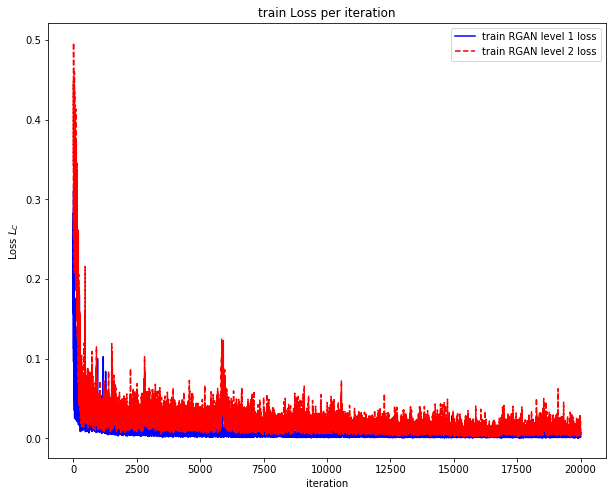

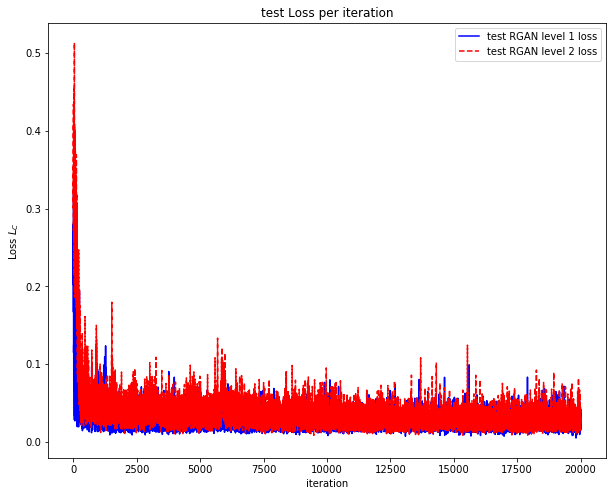

In [103]:
rgan_loss_plot(rgan_copy2_loss,rgan_copy3_loss,legend =[' RGAN level 1 loss',' RGAN level 2 loss'])

### RGAN on CGAN and GAN

In [110]:
rgan_copy2_loss = load_rgans_loss(8,'Q network')
rgan_loss = load_rgans_loss(6,'Q network')

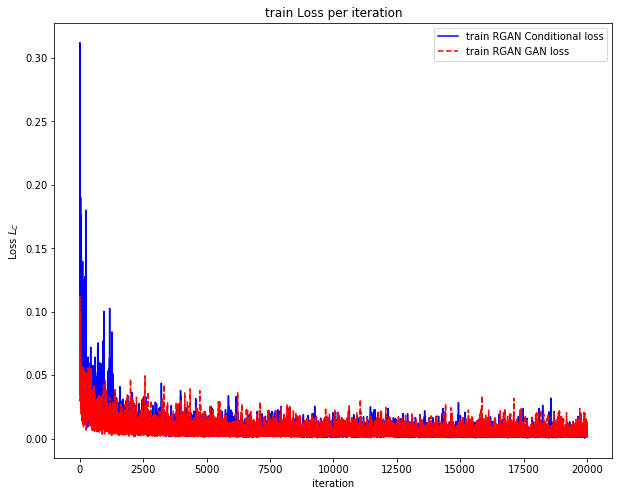

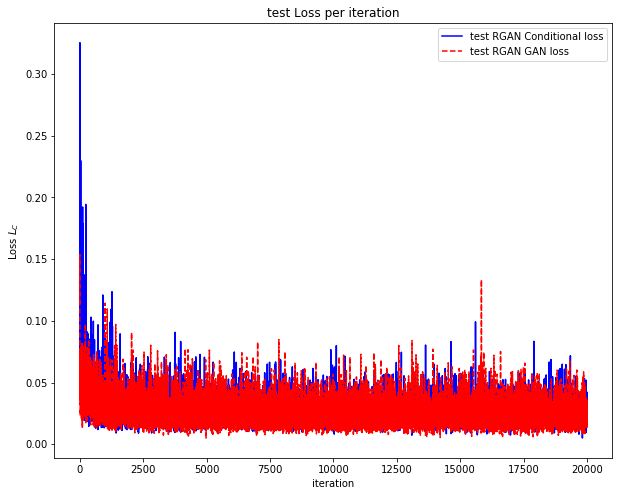

In [111]:
rgan_loss_plot(rgan_copy2_loss,rgan_loss,legend =[' RGAN Conditional loss',' RGAN GAN loss'])

In [112]:
rgan_copy2_loss = load_rgans_loss(8,'generator')
rgan_loss = load_rgans_loss(6,'generator')

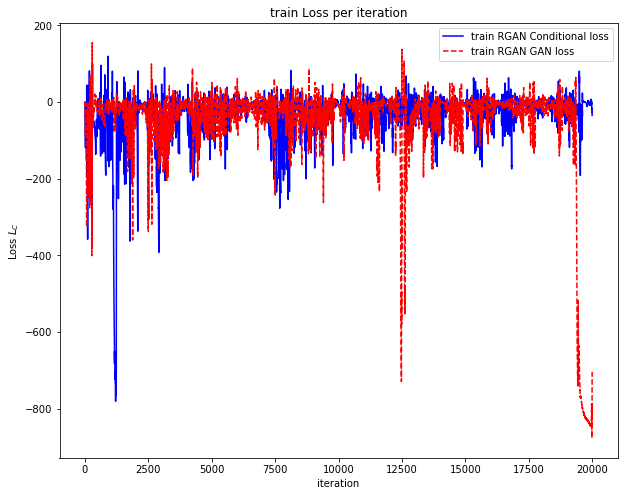

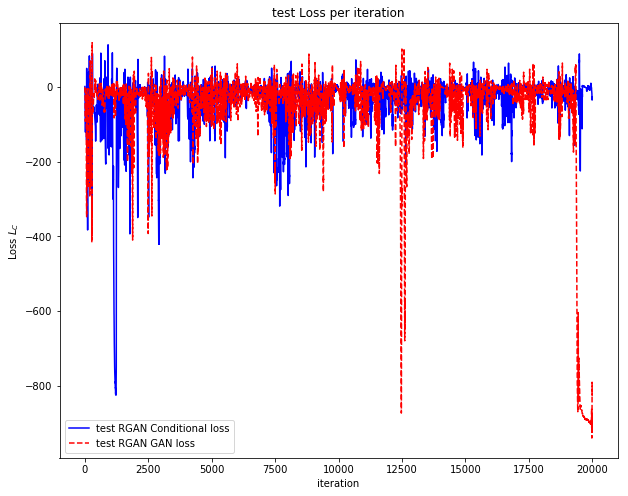

In [113]:
rgan_loss_plot(rgan_copy2_loss,rgan_loss,legend =[' RGAN Conditional loss',' RGAN GAN loss'])

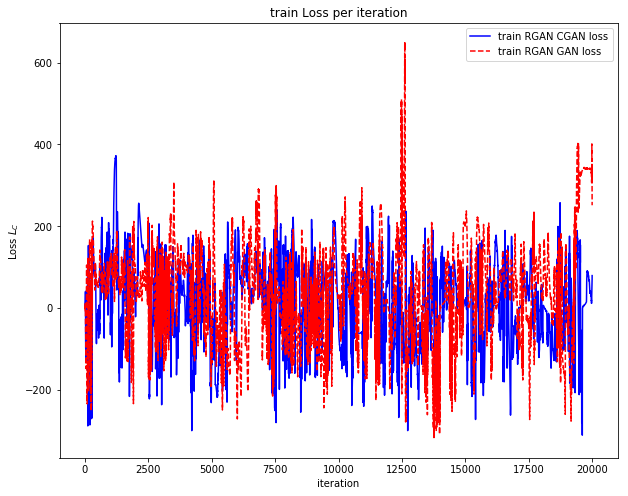

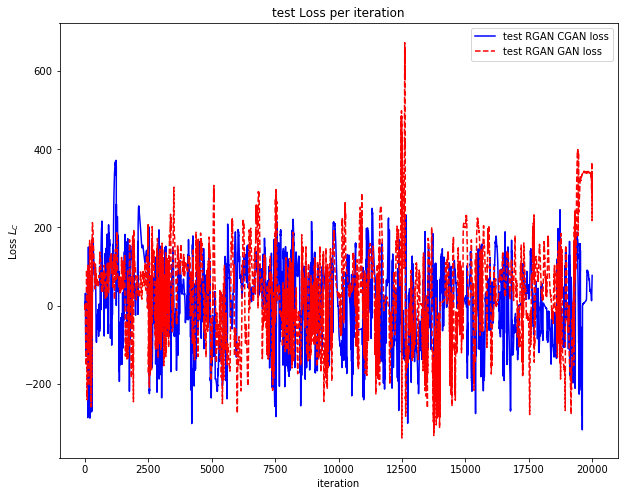

In [107]:
rgan_copy2_loss = load_rgans_loss(8,'discriminator')
rgan_loss = load_rgans_loss(6,'discriminator')

rgan_loss_plot(rgan_copy2_loss,rgan_loss,legend =[' RGAN CGAN loss',' RGAN GAN loss'])

### RGAN on GAN and ACGAN

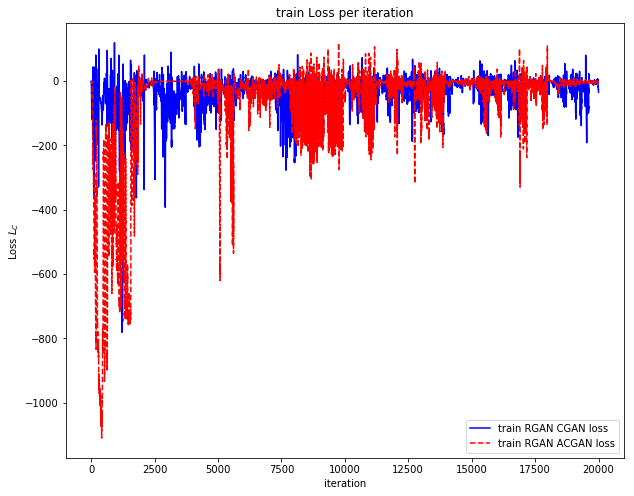

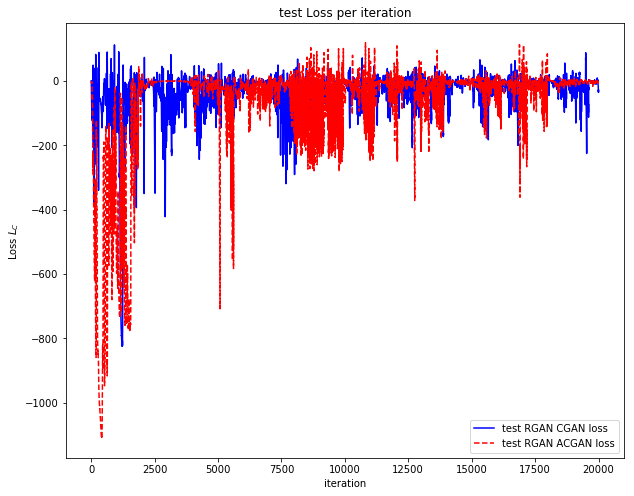

In [7]:
rgan_copy2_loss = load_rgans_loss(8,'generator')
rgan_copy5_loss = load_rgans_loss(5,'generator')

rgan_loss_plot(rgan_copy2_loss,rgan_copy5_loss,legend =[' RGAN CGAN loss',' RGAN ACGAN loss'])

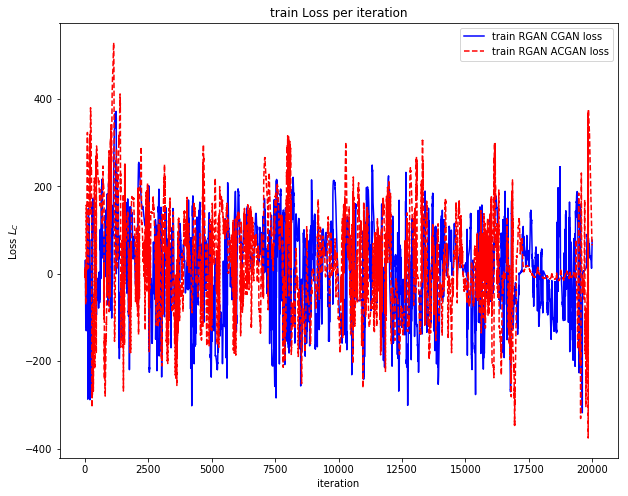

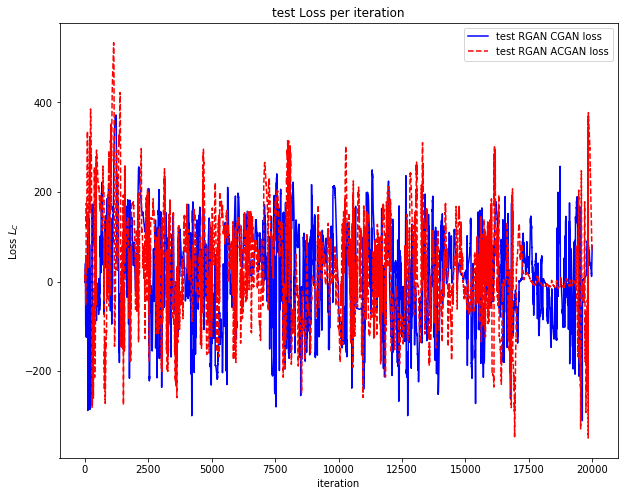

In [8]:
rgan_copy2_loss = load_rgans_loss(8,'discriminator')
rgan_copy5_loss = load_rgans_loss(12,'discriminator')

rgan_loss_plot(rgan_copy2_loss,rgan_copy5_loss,legend =[' RGAN CGAN loss',' RGAN ACGAN loss'])

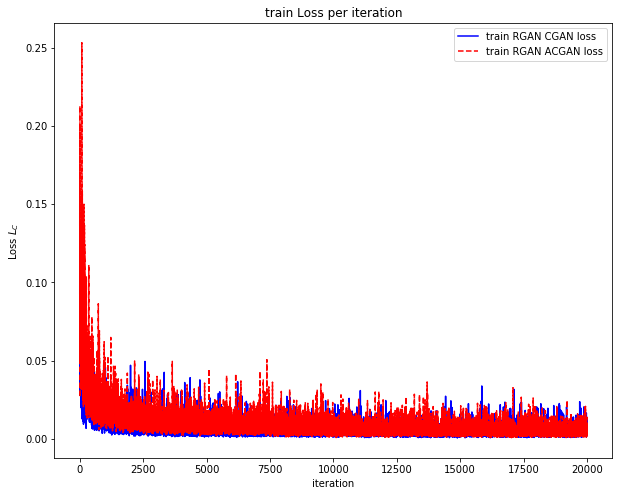

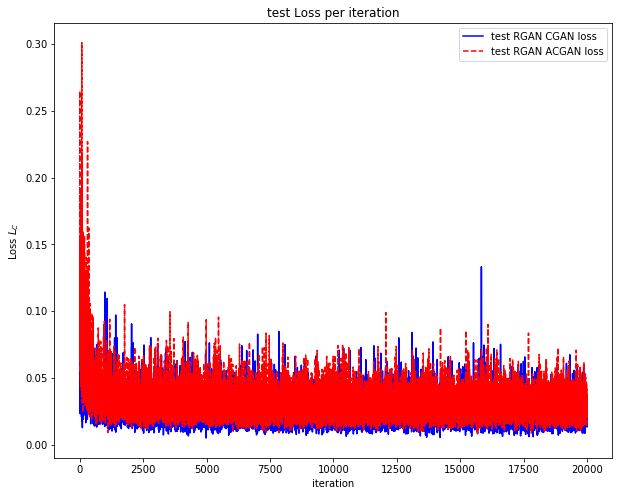

In [9]:
rgan_copy2_loss = load_rgans_loss(6,'Q network')
rgan_copy5_loss = load_rgans_loss(14,'Q network')

rgan_loss_plot(rgan_copy2_loss,rgan_copy5_loss,legend =[' RGAN CGAN loss',' RGAN ACGAN loss'])